<a href="https://colab.research.google.com/github/Nadian-Ali/ImageClassification/blob/main/ViT_HE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image classification with Vision Transformer

The base model is implemetned by Khalid Salma
 
**Author:** [Khalid Salama](https://www.linkedin.com/in/

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
!pip install -U tensorflow-addons

## Setup

In [6]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa

## Prepare the data

In [7]:
data_dir = '/content/drive/MyDrive/ImageClassificationData/DataHE'

In [8]:
batch_size = 16
img_height = 256
img_width = 256
input_shape = (img_height,img_width,3)

In [9]:
from keras.preprocessing import image

In [10]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  #color_mode = "grayscale",
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 190 files belonging to 2 classes.
Using 152 files for training.


In [11]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  #color_mode = "grayscale",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 190 files belonging to 2 classes.
Using 38 files for validation.


In [12]:
class_names = train_ds.class_names
num_classes = len(class_names)

In [13]:
print(class_names)

['AP', 'Lateral']


## Configure the hyperparameters

In [14]:
learning_rate = 0.001 #was 0.001
weight_decay = 0.0001
batch_size = 32
num_epochs = 150
image_size = 128  # We'll resize input images to this size
patch_size = 32  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 2
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [2048, 1024]  # Size of the dense layers of the final classifier


In [15]:
num_patches

16

## Use data augmentation

In [16]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
        layers.RandomFlip("horizontal"),
        #layers.RandomRotation(factor=0.02),
        layers.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ],
    name="data_augmentation",
)



## Implement multilayer perceptron (MLP)

In [17]:

def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x


## Implement patch creation as a layer

In [19]:

class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches


Let's display patches for a sample image

In [ ]:
#@title visualize patches 
import matplotlib.pyplot as plt

plt.figure(figsize=(4, 4))
image = x_train[np.random.choice(range(x_train.shape[0]))]
plt.imshow(image.astype("uint8"))
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")

## Implement the patch encoding layer



In [20]:

class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded


## Build the ViT model



In [21]:

def create_vit_classifier():
    inputs = layers.Input(shape=input_shape)
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(patch_size)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(1,activation = 'sigmoid')(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model


## Compile, train, and evaluate the mode

In [22]:
optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )



In [23]:
vit_classifier = create_vit_classifier()

vit_classifier.compile(
        optimizer=optimizer,
        loss=keras.losses.BinaryCrossentropy(from_logits=False),
        metrics=['accuracy']
            #keras.metrics.BinaryCrossentropy(name="accuracy"),
#            keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
        #],
    )

In [24]:
%cd drive/My Drive/ImageClassificationData

/content/drive/My Drive/ImageClassificationData


In [25]:
checkpoint_filepath = '/content/drive/MyDrive/ImageClassificationData/HECheckpoint/checkpoint'
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)



In [26]:
weight_for_0 = 190/(2*107)
weight_for_1 = 190/(2*83)
print(weight_for_0)
print(weight_for_1)
class_weight = {0: weight_for_0, 1: weight_for_1}

0.8878504672897196
1.144578313253012


In [27]:



history = vit_classifier.fit(
        x=train_ds,
        #y=val_ds,
        #batch_size=batch_size,
        validation_data=val_ds,
        epochs=num_epochs,
      #  validation_split=0.1,
        callbacks=[checkpoint_callback],
        class_weight = class_weight,
        #batch_size = 16,
    )

Epoch 1/150
10/10 [==============================] - 31s 741ms/step - loss: 1.6543 - accuracy: 0.4803 - val_loss: 0.8835 - val_accuracy: 0.5789
Epoch 2/150
10/10 [==============================] - 2s 196ms/step - loss: 1.4912 - accuracy: 0.4868 - val_loss: 1.0963 - val_accuracy: 0.5789
Epoch 3/150
10/10 [==============================] - 2s 195ms/step - loss: 1.3301 - accuracy: 0.5263 - val_loss: 1.8636 - val_accuracy: 0.4211
Epoch 4/150
10/10 [==============================] - 3s 261ms/step - loss: 1.5083 - accuracy: 0.5000 - val_loss: 0.5774 - val_accuracy: 0.6842
Epoch 5/150
10/10 [==============================] - 2s 196ms/step - loss: 1.0950 - accuracy: 0.6118 - val_loss: 0.7920 - val_accuracy: 0.5000
Epoch 6/150
10/10 [==============================] - 3s 243ms/step - loss: 1.2248 - accuracy: 0.5461 - val_loss: 0.5710 - val_accuracy: 0.6579
Epoch 7/150
10/10 [==============================] - 3s 242ms/step - loss: 0.8207 - accuracy: 0.6250 - val_loss: 0.5673 - val_accuracy: 0.710

In [29]:
import matplotlib.pyplot as plt

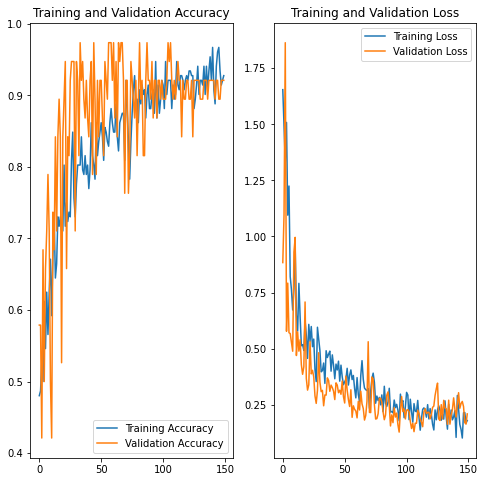

In [30]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(num_epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [31]:
import os
from os import listdir
from os.path import isfile, join
import shutil
import random

<h1>Load best model and do prediction</h1>

In [ ]:
checkpoint_filepath = '/content/drive/MyDrive/ImageClassificationData/checkpoint/checkpoint'
inference_model = create_vit_classifier()
inference_model.load_weights(checkpoint_filepath)


In [33]:
data_path =  '/content/drive/My Drive/ImageClassificationData/'
train_data_path = os.path.join(data_path,'TestHE')
image_names = [f for f in listdir(train_data_path) if isfile(join(train_data_path, f))]
#image_names

In [34]:
labels=[]
for name in image_names:
  if 'AP' in name:
    labels.append(0)
  else:
    labels.append(1)
labels = np.asarray(labels)

In [ ]:
i = 0 
test_image = os.path.join(data_path,'TestHE',image_names[i])
#print(test_image)
y = labels[i]
img = tf.keras.utils.load_img(
    test_image,
    #color_mode = "grayscale", 
    target_size=(img_height, img_width),
    )
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = inference_model.predict(img_array)

In [ ]:
predictions

array([[0.47103396]], dtype=float32)

In [ ]:

def select_image(image_names,data_path,random_image):
  random_image = random.choice(image_names)
  test_image = os.path.join(data_path,'Test',random_image)
  if 'AP' in test_image:
    class_name = 'AP'
  else:
    class_name = 'Lateral'
  return(test_image)


#for _ in range(10):


In [45]:
tp = 0
fp = 0
for name in image_names:
  test_image = os.path.join(data_path,'TestHE',name)
  #print(test_image)
  #test_image = select_image(image_names,data_path,name)
  img = tf.keras.utils.load_img(
      test_image,
      #color_mode = "grayscale", 
      target_size=(img_height, img_width),
      )
  img_array = tf.keras.utils.img_to_array(img)
  img_array = tf.expand_dims(img_array, 0) # Create a batch

  predictions = vit_classifier.predict(img_array)
 # acc,loss = inference_model.evaluate(img_array)
  
  if 'AP' in test_image:
    class_name = 'AP'
  else:
    class_name = 'Lateral'
  #print('\n','True image class:',class_name)

  #print(test_image)
  #print(predictions)
  if predictions<0.4:
    print('\n',name,'    True image class:',class_name,'             predicted class is Lateral   ', predictions)
  else:
    print('\n',name,'   True image class:',class_name,'              predicted class is AP      ',predictions)  

  total_num_test_images = len(image_names)

  if (class_name == 'Lateral' and predictions <0.3)  or (class_name == 'AP' and predictions >0.3):
    tp = tp + 1 
  else:
    fp = fp + 1

print(tp)
print(fp)


 211_AP.png    True image class: AP               predicted class is AP       [[0.5288622]]

 198_Lateral.png     True image class: Lateral              predicted class is Lateral    [[0.2011669]]

 196_Lateral.png    True image class: Lateral               predicted class is AP       [[0.6996219]]

 195_Lateral.png     True image class: Lateral              predicted class is Lateral    [[0.02507585]]

 210_AP.png    True image class: AP               predicted class is AP       [[0.7527477]]

 209_AP.png     True image class: AP              predicted class is Lateral    [[0.3191436]]

 201_Lateral.png     True image class: Lateral              predicted class is Lateral    [[0.20326555]]

 194_Lateral.png     True image class: Lateral              predicted class is Lateral    [[0.05020073]]

 199_Lateral.png     True image class: Lateral              predicted class is Lateral    [[0.03935301]]

 217_AP.png     True image class: AP              predicted class is Lateral    [[0.11

In [ ]:
total_num_test_images

27

In [ ]:
tp

12

In [ ]:
fp

15